# Imports

In [13]:
import gdown
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import timm
import torch
import torch.nn.functional as F

from collections import defaultdict
from PIL import Image, ImageOps
from tqdm import tqdm
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, ConcatDataset, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Functions

In [14]:
# Plotar imagens aleatórias

def plot_random_images(dataset, gray=False):
    random_idx = np.random.randint(0, len(dataset), 9)

    plt.figure(figsize=(10, 10))
    for i, img_index in enumerate(random_idx):
        plt.subplot(3,3,i+1)
        plt.grid(False)
        image, label = dataset[img_index]
        plt.title(label)
        if gray:
          plt.imshow(image.permute(1,2,0), cmap='gray')
        else:
          plt.imshow(image.permute(1,2,0))
    
    plt.show()

In [15]:
# Plotar matriz de confusão

def plot_confusion_matrix_with_diagonal(
    cm,
    labels,
    title_matrix='Matriz de Confusão Normalizada',
    title_diagonal='Class Accuracies',
    extra_diagonals=None,
    extra_names=None
):

    row_sums = cm.sum(axis=1)

    sorted_indices = np.argsort(row_sums)[::-1]

    cm_sorted = cm[sorted_indices][:, sorted_indices]
    labels_sorted = [labels[i] for i in sorted_indices]

    cm_normalized = cm_sorted.astype('float') / cm_sorted.sum(axis=1)[:, np.newaxis]
    diagonal = np.diag(cm_normalized)

    accuracy_rows = [diagonal]
    accuracy_labels = [title_diagonal]

    if extra_diagonals is not None:
        accuracy_rows += extra_diagonals
    if extra_names is not None:
        accuracy_labels += extra_names
    elif extra_diagonals:
        accuracy_labels += [f'Modelo {i+1}' for i in range(len(extra_diagonals))]

    sns.set(font_scale=1.0)

    fig = plt.figure(figsize=(14, 16))

    ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=4)
    sns.heatmap(cm_normalized, annot=np.round(cm_normalized, 2), fmt=".2f", cmap='flare',
                xticklabels=labels_sorted, yticklabels=labels_sorted, linewidths=0.5,
                cbar=True, annot_kws={"size": 8}, ax=ax1)
    ax1.set_title(title_matrix)
    ax1.set_xlabel('Previsão')
    ax1.set_ylabel('Real')
    ax1.tick_params(axis='x', rotation=90)
    ax1.tick_params(axis='y', rotation=0)

    ax2 = plt.subplot2grid((6, 1), (4, 0), rowspan=2)
    sns.heatmap(accuracy_rows, annot=np.round(accuracy_rows, 2), fmt=".2f", cmap='flare',
                xticklabels=labels_sorted, yticklabels=accuracy_labels, cbar=True,
                linewidths=0.5, ax=ax2)
    ax2.tick_params(axis='x', rotation=90)
    ax2.tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.show()

In [16]:
# Função auxiliar da train_classification()

def _train_step_classification(classifier_model, dataloader, criterion, optimizer, scheduler, device):
    classifier_model.train()

    total_loss = 0
    all_preds = []
    all_targets = []

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = classifier_model(X)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)

        y_pred_labels = torch.argmax(y_pred, axis=1)
        all_preds.extend(y_pred_labels.detach().cpu().numpy())
        all_targets.extend(y.detach().cpu().numpy())

    if scheduler:
        scheduler.step()

    mean_loss = total_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='binary', zero_division=0)

    return mean_loss, accuracy, precision, recall, f1

In [17]:
# Função auxiliar da train_classification()

def _test_step_classification(classifier_model, dataloader, criterion, device):
    classifier_model.eval()

    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = classifier_model(X)
            loss = criterion(y_pred, y)

            total_loss += loss.item() * X.size(0)

            y_pred_labels = torch.argmax(y_pred, axis=1)
            all_preds.extend(y_pred_labels.detach().cpu().numpy())
            all_targets.extend(y.detach().cpu().numpy())

    mean_loss = total_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='binary', zero_division=0)

    return mean_loss, accuracy, precision, recall, f1

In [18]:
# Treina rede de classificação
def train_classification(classifier_model, train_dataloader, val_dataloader, criterion, epochs, optimizers, schedulers, device='cpu', verbose=True):
    # Dicionário de métricas com chaves em minúsculas para compatibilidade com a função de plot
    metrics = {'train_loss': [], 'train_accuracy': [], 'train_precision': [], 'train_recall': [], 'train_f1': [],
               'val_loss': [], 'val_accuracy': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}

    current_optimizer_number = 0
    for optimizer, scheduler, num_epochs in zip(optimizers, schedulers, epochs):
        current_optimizer_number += 1
        for epoch in tqdm(range(1, num_epochs+1), desc=f'Training with optimizer {current_optimizer_number}'):
            current_lr = optimizer.param_groups[0]["lr"]

            # Passo de Treino (sem alterações aqui)
            train_loss, train_accuracy, train_precision, train_recall, train_f1 = _train_step_classification(classifier_model, train_dataloader, criterion, optimizer, scheduler, device)

            # Passo de Validação (agora usando val_dataloader)
            val_loss, val_accuracy, val_precision, val_recall, val_f1 = _test_step_classification(classifier_model, val_dataloader, criterion, device)

            # Armazenando métricas de treino
            metrics['train_loss'].append(train_loss)
            metrics['train_accuracy'].append(train_accuracy)
            metrics['train_precision'].append(train_precision)
            metrics['train_recall'].append(train_recall)
            metrics['train_f1'].append(train_f1)

            # Armazenando métricas de validação com a nomenclatura correta
            metrics['val_loss'].append(val_loss)
            metrics['val_accuracy'].append(val_accuracy)
            metrics['val_precision'].append(val_precision)
            metrics['val_recall'].append(val_recall)
            metrics['val_f1'].append(val_f1)

            if verbose:
                # Mensagem de print atualizada para "Val"
                print(f'\\nEPOCH {epoch} | Current learning rate: {current_lr:.8f}\\n'
                      f'Train loss: {train_loss:.4f} | Train accuracy: {train_accuracy:.4f} | Train precision: {train_precision:.4f} | Train recall: {train_recall:.4f} | Train F1: {train_f1:.4f}\\n'
                      f'Val loss:   {val_loss:.4f} | Val accuracy:   {val_accuracy:.4f} | Val precision:   {val_precision:.4f} | Val recall:   {val_recall:.4f} | Val F1:   {val_f1:.4f}\\n')

    return metrics

In [19]:
def test_classification(classifier_model, test_dataloader, criterion, device='cpu', verbose=True):
    metrics = {'Test loss': [], 'Test accuracy': [], 'Test precision': [], 'Test recall': [], 'Test F1': []}

    test_loss, test_accuracy, test_precision, test_recall, test_f1 = _test_step_classification(classifier_model, test_dataloader, criterion, device)

    metrics['Test loss'].append(test_loss)
    metrics['Test accuracy'].append(test_accuracy)
    metrics['Test precision'].append(test_precision)
    metrics['Test recall'].append(test_recall)
    metrics['Test F1'].append(test_f1)

    if verbose:
        print(f'Test loss: {test_loss:.4f} | Test accuracy: {test_accuracy:.4f} | Test precision: {test_precision:.4f} | Test recall: {test_recall:.4f} | Test F1: {test_f1:.4f}\n')

    return metrics

In [20]:
# Retorna matriz de confusão

def get_conf_matrix(classifier_model, dataloader, device):
    classifier_model.eval()

    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = classifier_model(X).argmax(dim=1).cpu()

            all_preds.extend(y_pred.cpu())
            all_targets.extend(y.cpu())

    conf_matrix = confusion_matrix(all_targets, all_preds)

    return conf_matrix

In [21]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(15, 5))

    # --- Loss ---
    plt.subplot(1, 3, 1)
    plt.plot(epochs, metrics['train_loss'], label='Treino')
    plt.plot(epochs, metrics['val_loss'], label='Validação')
    plt.title("Loss")
    plt.xlabel("Ephocs")
    plt.ylabel("Loss")
    plt.legend()

    # --- Accuracy ---
    plt.subplot(1, 3, 2)
    plt.plot(epochs, metrics['train_accuracy'], label='Treino')
    plt.plot(epochs, metrics['val_accuracy'], label='Validação')
    plt.title("Accuracy")
    plt.xlabel("Ephocs")
    plt.ylabel("Accuracy")
    plt.legend()

    # --- F1 ---
    plt.subplot(1, 3, 3)
    plt.plot(epochs, metrics['train_f1'], label='Treino')
    plt.plot(epochs, metrics['val_f1'], label='Validação')
    plt.title("F1")
    plt.xlabel("Ephocs")
    plt.ylabel("F1")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [22]:
# Wrapper que aplica transform no subset
class TransformedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset   # pode ser random_split (Subset)
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]   # retorna PIL Image + label
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# Dataset

In [23]:
import shutil, os

# Caminho de origem (somente leitura)
src = "/kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (PKG)/C-NMC_training_data"

# Caminho de destino (gravável)
dst = "/kaggle/working/C-NMC_training_data"

# Copia a pasta inteira para o working
if not os.path.exists(dst):
    shutil.copytree(src, dst)

# Agora podemos renomear as pastas dentro de cada fold
for fold in ["fold_0", "fold_1", "fold_2"]:
    fold_path = os.path.join(dst, fold)

    # Renomeia ALL → 1
    all_path = os.path.join(fold_path, "all")
    if os.path.exists(all_path):
        os.rename(all_path, os.path.join(fold_path, "1"))

    # Renomeia HEM → 0
    hem_path = os.path.join(fold_path, "hem")
    if os.path.exists(hem_path):
        os.rename(hem_path, os.path.join(fold_path, "0"))

In [24]:
train_transform = transforms.Compose([
    transforms.CenterCrop(224),               # necessário
    transforms.RandomHorizontalFlip(p=0.5),      # só no treino
    transforms.RandomVerticalFlip(p=0.5),        # só no treino
    transforms.RandomAffine(degrees=30, translate=(0.00, 0.00), scale=(1.00, 1.00), shear=5),# só no treino
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.CenterCrop(224),  # necessário
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.CenterCrop(224),  # necessário
    transforms.ToTensor(),
])

In [25]:
fold_0 = ImageFolder(os.path.join(dst, "fold_0"))
fold_1 = ImageFolder(os.path.join(dst, "fold_1"))
fold_2 = ImageFolder(os.path.join(dst, "fold_2"))

dataset = ConcatDataset([fold_0, fold_1, fold_2])

In [26]:
print(fold_0.class_to_idx)

{'0': 0, '1': 1}


In [27]:
seed = 42
g = torch.Generator().manual_seed(seed)

# Tamanhos
n_total = len(dataset)
n_test = int(0.10 * n_total)
n_val  = int(0.20 * n_total)
n_train = n_total - n_val - n_test

# Split
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [n_train, n_val, n_test], generator=g
)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Train: 7463 | Val: 2132 | Test: 1066


In [28]:
train_dataset = TransformedDataset(train_dataset, transform=train_transform)
val_dataset   = TransformedDataset(val_dataset,   transform=val_transform)
test_dataset  = TransformedDataset(test_dataset,  transform=test_transform)

In [29]:
# Conta quantos exemplos existem de cada classe
targets = [y for _, y in train_dataset]  # pode ser custoso se dataset for grande

class_sample_counts = np.bincount(targets)  # [num_classe0, num_classe1]
weights = 1. / class_sample_counts          # inverso da frequência

# Cria vetor de pesos para cada exemplo
sample_weights = [weights[t] for t in targets]

# Sampler balanceado
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=30000,   # total de amostras desejadas
    replacement=True     # permite repetir para balancear
)

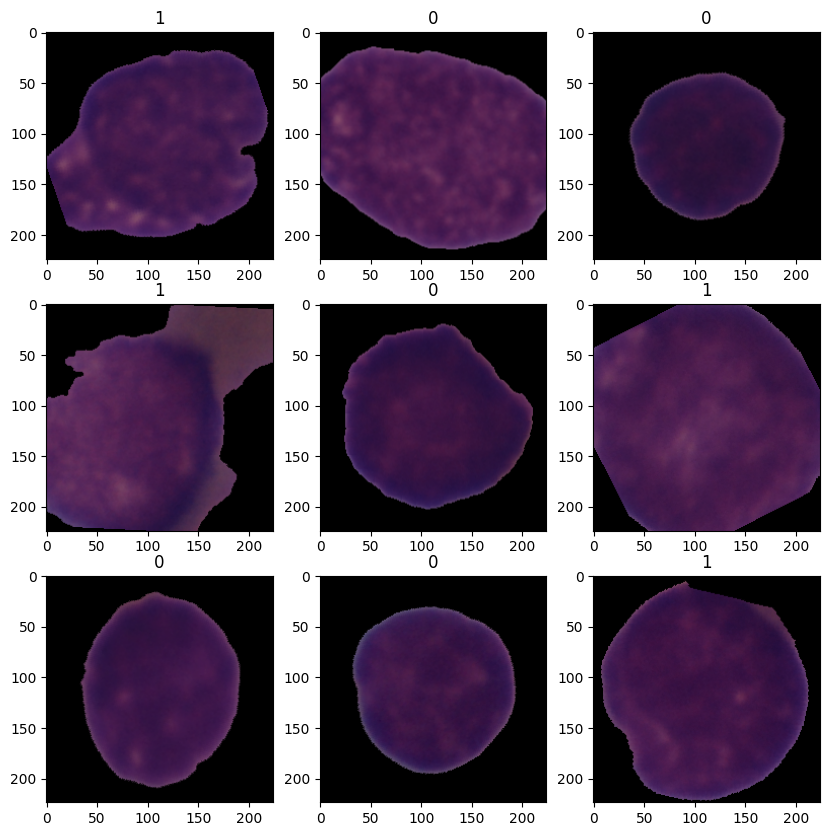

In [30]:
plot_random_images(train_dataset)

# Model

In [31]:
class SwinTransformerTiny(nn.Module):
    def __init__(self, drop_path_rate=0, drop_rate=0, attn_drop_rate=0):
        super().__init__()
        self.model = timm.create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=True,
            num_classes=2,
            drop_path_rate=drop_path_rate,
            drop_rate=drop_rate,
            attn_drop_rate=attn_drop_rate
        )


    def forward(self, x):
        return self.model(x)

# Training

In [32]:
# Dispositivo (CPU ou GPU)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [33]:
train_dataloader = DataLoader(train_dataset, batch_size=128, sampler=sampler, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)

# Classification

In [34]:


classifier_model = SwinTransformerTiny(drop_path_rate=0.15, drop_rate=0.1, attn_drop_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss().to(device)

optimizer = optim.AdamW(classifier_model.parameters(), lr=1e-4, weight_decay=5e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, 0.9)

optimizers = [optimizer]
schedulers = [scheduler]
epochs = [50]



model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [35]:


# Baixando parâmetros do drive (se necessário)
#gdown.download('https://drive.google.com/file/d/1b4C0jr9QEnslJketPI9IkWPZVXivjLqr/view?usp=drive_link', 'parameters.pth', fuzzy=True, quiet=False)

In [36]:


# Carregando parâmetros
#classifier_model.load_state_dict(torch.load('/kaggle/working/parameters.pth'))



In [37]:
# Treino
metrics = train_classification(classifier_model, train_dataloader, val_dataloader, criterion, epochs, optimizers, schedulers, device)

Training with optimizer 1:   2%|▏         | 1/50 [03:44<3:03:20, 224.50s/it]

\nEPOCH 1 | Current learning rate: 0.00010000\nTrain loss: 1.4007 | Train accuracy: 0.8443 | Train precision: 0.8168 | Train recall: 0.8878 | Train F1: 0.8508\nVal loss:   0.2965 | Val accuracy:   0.8940 | Val precision:   0.9742 | Val recall:   0.8659 | Val F1:   0.9169\n


Training with optimizer 1:   4%|▍         | 2/50 [07:26<2:58:11, 222.74s/it]

\nEPOCH 2 | Current learning rate: 0.00009000\nTrain loss: 0.6852 | Train accuracy: 0.9310 | Train precision: 0.9152 | Train recall: 0.9478 | Train F1: 0.9312\nVal loss:   0.1103 | Val accuracy:   0.9587 | Val precision:   0.9675 | Val recall:   0.9715 | Val F1:   0.9695\n


Training with optimizer 1:   6%|▌         | 3/50 [11:07<2:54:05, 222.25s/it]

\nEPOCH 3 | Current learning rate: 0.00008100\nTrain loss: 0.4228 | Train accuracy: 0.9598 | Train precision: 0.9521 | Train recall: 0.9684 | Train F1: 0.9602\nVal loss:   0.0909 | Val accuracy:   0.9695 | Val precision:   0.9705 | Val recall:   0.9847 | Val F1:   0.9776\n


Training with optimizer 1:   8%|▊         | 4/50 [14:49<2:50:14, 222.05s/it]

\nEPOCH 4 | Current learning rate: 0.00007290\nTrain loss: 0.3020 | Train accuracy: 0.9720 | Train precision: 0.9687 | Train recall: 0.9753 | Train F1: 0.9720\nVal loss:   0.0839 | Val accuracy:   0.9695 | Val precision:   0.9900 | Val recall:   0.9646 | Val F1:   0.9771\n


Training with optimizer 1:  10%|█         | 5/50 [18:30<2:46:22, 221.84s/it]

\nEPOCH 5 | Current learning rate: 0.00006561\nTrain loss: 0.2067 | Train accuracy: 0.9804 | Train precision: 0.9786 | Train recall: 0.9823 | Train F1: 0.9804\nVal loss:   0.0972 | Val accuracy:   0.9705 | Val precision:   0.9879 | Val recall:   0.9680 | Val F1:   0.9779\n


Training with optimizer 1:  12%|█▏        | 6/50 [22:12<2:42:41, 221.86s/it]

\nEPOCH 6 | Current learning rate: 0.00005905\nTrain loss: 0.1649 | Train accuracy: 0.9845 | Train precision: 0.9824 | Train recall: 0.9867 | Train F1: 0.9846\nVal loss:   0.0948 | Val accuracy:   0.9709 | Val precision:   0.9914 | Val recall:   0.9653 | Val F1:   0.9782\n


Training with optimizer 1:  14%|█▍        | 7/50 [25:54<2:39:03, 221.94s/it]

\nEPOCH 7 | Current learning rate: 0.00005314\nTrain loss: 0.1112 | Train accuracy: 0.9903 | Train precision: 0.9897 | Train recall: 0.9907 | Train F1: 0.9902\nVal loss:   0.0678 | Val accuracy:   0.9789 | Val precision:   0.9834 | Val recall:   0.9854 | Val F1:   0.9844\n


Training with optimizer 1:  16%|█▌        | 8/50 [29:36<2:35:18, 221.86s/it]

\nEPOCH 8 | Current learning rate: 0.00004783\nTrain loss: 0.1041 | Train accuracy: 0.9909 | Train precision: 0.9906 | Train recall: 0.9912 | Train F1: 0.9909\nVal loss:   0.0962 | Val accuracy:   0.9709 | Val precision:   0.9928 | Val recall:   0.9639 | Val F1:   0.9781\n


Training with optimizer 1:  18%|█▊        | 9/50 [33:18<2:31:36, 221.86s/it]

\nEPOCH 9 | Current learning rate: 0.00004305\nTrain loss: 0.0760 | Train accuracy: 0.9932 | Train precision: 0.9932 | Train recall: 0.9931 | Train F1: 0.9931\nVal loss:   0.1148 | Val accuracy:   0.9700 | Val precision:   0.9811 | Val recall:   0.9743 | Val F1:   0.9777\n


Training with optimizer 1:  20%|██        | 10/50 [37:00<2:27:52, 221.80s/it]

\nEPOCH 10 | Current learning rate: 0.00003874\nTrain loss: 0.0563 | Train accuracy: 0.9954 | Train precision: 0.9948 | Train recall: 0.9961 | Train F1: 0.9954\nVal loss:   0.0751 | Val accuracy:   0.9855 | Val precision:   0.9889 | Val recall:   0.9896 | Val F1:   0.9892\n


Training with optimizer 1:  22%|██▏       | 11/50 [40:42<2:24:12, 221.86s/it]

\nEPOCH 11 | Current learning rate: 0.00003487\nTrain loss: 0.0450 | Train accuracy: 0.9962 | Train precision: 0.9958 | Train recall: 0.9965 | Train F1: 0.9961\nVal loss:   0.1507 | Val accuracy:   0.9695 | Val precision:   0.9928 | Val recall:   0.9618 | Val F1:   0.9771\n


Training with optimizer 1:  24%|██▍       | 12/50 [44:24<2:20:31, 221.88s/it]

\nEPOCH 12 | Current learning rate: 0.00003138\nTrain loss: 0.0411 | Train accuracy: 0.9966 | Train precision: 0.9970 | Train recall: 0.9962 | Train F1: 0.9966\nVal loss:   0.0761 | Val accuracy:   0.9859 | Val precision:   0.9889 | Val recall:   0.9903 | Val F1:   0.9896\n


Training with optimizer 1:  26%|██▌       | 13/50 [48:05<2:16:49, 221.88s/it]

\nEPOCH 13 | Current learning rate: 0.00002824\nTrain loss: 0.0355 | Train accuracy: 0.9967 | Train precision: 0.9963 | Train recall: 0.9970 | Train F1: 0.9967\nVal loss:   0.0867 | Val accuracy:   0.9826 | Val precision:   0.9834 | Val recall:   0.9910 | Val F1:   0.9872\n


Training with optimizer 1:  28%|██▊       | 14/50 [51:47<2:13:08, 221.90s/it]

\nEPOCH 14 | Current learning rate: 0.00002542\nTrain loss: 0.0347 | Train accuracy: 0.9970 | Train precision: 0.9973 | Train recall: 0.9967 | Train F1: 0.9970\nVal loss:   0.0782 | Val accuracy:   0.9841 | Val precision:   0.9902 | Val recall:   0.9861 | Val F1:   0.9882\n


Training with optimizer 1:  30%|███       | 15/50 [55:29<2:09:25, 221.87s/it]

\nEPOCH 15 | Current learning rate: 0.00002288\nTrain loss: 0.0333 | Train accuracy: 0.9973 | Train precision: 0.9973 | Train recall: 0.9973 | Train F1: 0.9973\nVal loss:   0.0768 | Val accuracy:   0.9831 | Val precision:   0.9902 | Val recall:   0.9847 | Val F1:   0.9875\n


Training with optimizer 1:  32%|███▏      | 16/50 [59:11<2:05:42, 221.83s/it]

\nEPOCH 16 | Current learning rate: 0.00002059\nTrain loss: 0.0202 | Train accuracy: 0.9982 | Train precision: 0.9981 | Train recall: 0.9983 | Train F1: 0.9982\nVal loss:   0.0880 | Val accuracy:   0.9859 | Val precision:   0.9875 | Val recall:   0.9917 | Val F1:   0.9896\n


Training with optimizer 1:  34%|███▍      | 17/50 [1:02:53<2:02:01, 221.85s/it]

\nEPOCH 17 | Current learning rate: 0.00001853\nTrain loss: 0.0229 | Train accuracy: 0.9981 | Train precision: 0.9980 | Train recall: 0.9982 | Train F1: 0.9981\nVal loss:   0.0807 | Val accuracy:   0.9845 | Val precision:   0.9889 | Val recall:   0.9882 | Val F1:   0.9885\n


Training with optimizer 1:  36%|███▌      | 18/50 [1:06:35<1:58:19, 221.85s/it]

\nEPOCH 18 | Current learning rate: 0.00001668\nTrain loss: 0.0136 | Train accuracy: 0.9987 | Train precision: 0.9986 | Train recall: 0.9988 | Train F1: 0.9987\nVal loss:   0.0972 | Val accuracy:   0.9836 | Val precision:   0.9848 | Val recall:   0.9910 | Val F1:   0.9879\n


Training with optimizer 1:  38%|███▊      | 19/50 [1:10:16<1:54:37, 221.85s/it]

\nEPOCH 19 | Current learning rate: 0.00001501\nTrain loss: 0.0253 | Train accuracy: 0.9980 | Train precision: 0.9981 | Train recall: 0.9980 | Train F1: 0.9981\nVal loss:   0.0890 | Val accuracy:   0.9812 | Val precision:   0.9909 | Val recall:   0.9812 | Val F1:   0.9860\n


Training with optimizer 1:  40%|████      | 20/50 [1:13:58<1:50:54, 221.82s/it]

\nEPOCH 20 | Current learning rate: 0.00001351\nTrain loss: 0.0131 | Train accuracy: 0.9991 | Train precision: 0.9993 | Train recall: 0.9988 | Train F1: 0.9991\nVal loss:   0.0806 | Val accuracy:   0.9859 | Val precision:   0.9896 | Val recall:   0.9896 | Val F1:   0.9896\n


Training with optimizer 1:  42%|████▏     | 21/50 [1:17:40<1:47:12, 221.81s/it]

\nEPOCH 21 | Current learning rate: 0.00001216\nTrain loss: 0.0171 | Train accuracy: 0.9984 | Train precision: 0.9983 | Train recall: 0.9985 | Train F1: 0.9984\nVal loss:   0.0847 | Val accuracy:   0.9855 | Val precision:   0.9869 | Val recall:   0.9917 | Val F1:   0.9893\n


Training with optimizer 1:  44%|████▍     | 22/50 [1:21:22<1:43:29, 221.76s/it]

\nEPOCH 22 | Current learning rate: 0.00001094\nTrain loss: 0.0096 | Train accuracy: 0.9993 | Train precision: 0.9991 | Train recall: 0.9995 | Train F1: 0.9993\nVal loss:   0.0869 | Val accuracy:   0.9859 | Val precision:   0.9882 | Val recall:   0.9910 | Val F1:   0.9896\n


Training with optimizer 1:  46%|████▌     | 23/50 [1:25:03<1:39:46, 221.73s/it]

\nEPOCH 23 | Current learning rate: 0.00000985\nTrain loss: 0.0118 | Train accuracy: 0.9990 | Train precision: 0.9991 | Train recall: 0.9989 | Train F1: 0.9990\nVal loss:   0.0775 | Val accuracy:   0.9873 | Val precision:   0.9903 | Val recall:   0.9910 | Val F1:   0.9906\n


Training with optimizer 1:  48%|████▊     | 24/50 [1:28:45<1:36:03, 221.69s/it]

\nEPOCH 24 | Current learning rate: 0.00000886\nTrain loss: 0.0071 | Train accuracy: 0.9993 | Train precision: 0.9992 | Train recall: 0.9994 | Train F1: 0.9993\nVal loss:   0.0768 | Val accuracy:   0.9873 | Val precision:   0.9910 | Val recall:   0.9903 | Val F1:   0.9906\n


Training with optimizer 1:  50%|█████     | 25/50 [1:32:27<1:32:24, 221.76s/it]

\nEPOCH 25 | Current learning rate: 0.00000798\nTrain loss: 0.0073 | Train accuracy: 0.9995 | Train precision: 0.9997 | Train recall: 0.9994 | Train F1: 0.9995\nVal loss:   0.0811 | Val accuracy:   0.9869 | Val precision:   0.9869 | Val recall:   0.9937 | Val F1:   0.9903\n


Training with optimizer 1:  52%|█████▏    | 26/50 [1:36:08<1:28:40, 221.69s/it]

\nEPOCH 26 | Current learning rate: 0.00000718\nTrain loss: 0.0077 | Train accuracy: 0.9992 | Train precision: 0.9991 | Train recall: 0.9993 | Train F1: 0.9992\nVal loss:   0.0805 | Val accuracy:   0.9869 | Val precision:   0.9916 | Val recall:   0.9889 | Val F1:   0.9903\n


Training with optimizer 1:  54%|█████▍    | 27/50 [1:39:50<1:25:00, 221.75s/it]

\nEPOCH 27 | Current learning rate: 0.00000646\nTrain loss: 0.0102 | Train accuracy: 0.9990 | Train precision: 0.9992 | Train recall: 0.9989 | Train F1: 0.9990\nVal loss:   0.0814 | Val accuracy:   0.9902 | Val precision:   0.9896 | Val recall:   0.9958 | Val F1:   0.9927\n


Training with optimizer 1:  56%|█████▌    | 28/50 [1:43:32<1:21:18, 221.75s/it]

\nEPOCH 28 | Current learning rate: 0.00000581\nTrain loss: 0.0113 | Train accuracy: 0.9990 | Train precision: 0.9990 | Train recall: 0.9990 | Train F1: 0.9990\nVal loss:   0.0774 | Val accuracy:   0.9859 | Val precision:   0.9875 | Val recall:   0.9917 | Val F1:   0.9896\n


Training with optimizer 1:  58%|█████▊    | 29/50 [1:47:14<1:17:36, 221.76s/it]

\nEPOCH 29 | Current learning rate: 0.00000523\nTrain loss: 0.0068 | Train accuracy: 0.9994 | Train precision: 0.9994 | Train recall: 0.9994 | Train F1: 0.9994\nVal loss:   0.0762 | Val accuracy:   0.9883 | Val precision:   0.9910 | Val recall:   0.9917 | Val F1:   0.9913\n


Training with optimizer 1:  60%|██████    | 30/50 [1:50:56<1:13:55, 221.75s/it]

\nEPOCH 30 | Current learning rate: 0.00000471\nTrain loss: 0.0068 | Train accuracy: 0.9993 | Train precision: 0.9993 | Train recall: 0.9993 | Train F1: 0.9993\nVal loss:   0.0809 | Val accuracy:   0.9883 | Val precision:   0.9889 | Val recall:   0.9937 | Val F1:   0.9913\n


Training with optimizer 1:  62%|██████▏   | 31/50 [1:54:37<1:10:13, 221.78s/it]

\nEPOCH 31 | Current learning rate: 0.00000424\nTrain loss: 0.0074 | Train accuracy: 0.9994 | Train precision: 0.9994 | Train recall: 0.9994 | Train F1: 0.9994\nVal loss:   0.0873 | Val accuracy:   0.9873 | Val precision:   0.9896 | Val recall:   0.9917 | Val F1:   0.9906\n


Training with optimizer 1:  64%|██████▍   | 32/50 [1:58:19<1:06:31, 221.75s/it]

\nEPOCH 32 | Current learning rate: 0.00000382\nTrain loss: 0.0062 | Train accuracy: 0.9994 | Train precision: 0.9993 | Train recall: 0.9995 | Train F1: 0.9994\nVal loss:   0.0858 | Val accuracy:   0.9878 | Val precision:   0.9889 | Val recall:   0.9931 | Val F1:   0.9910\n


Training with optimizer 1:  66%|██████▌   | 33/50 [2:02:01<1:02:50, 221.78s/it]

\nEPOCH 33 | Current learning rate: 0.00000343\nTrain loss: 0.0052 | Train accuracy: 0.9996 | Train precision: 0.9997 | Train recall: 0.9996 | Train F1: 0.9996\nVal loss:   0.0822 | Val accuracy:   0.9883 | Val precision:   0.9896 | Val recall:   0.9931 | Val F1:   0.9913\n


Training with optimizer 1:  68%|██████▊   | 34/50 [2:05:43<59:09, 221.82s/it]  

\nEPOCH 34 | Current learning rate: 0.00000309\nTrain loss: 0.0043 | Train accuracy: 0.9997 | Train precision: 0.9997 | Train recall: 0.9997 | Train F1: 0.9997\nVal loss:   0.0781 | Val accuracy:   0.9878 | Val precision:   0.9903 | Val recall:   0.9917 | Val F1:   0.9910\n


Training with optimizer 1:  70%|███████   | 35/50 [2:09:25<55:28, 221.90s/it]

\nEPOCH 35 | Current learning rate: 0.00000278\nTrain loss: 0.0050 | Train accuracy: 0.9996 | Train precision: 0.9995 | Train recall: 0.9997 | Train F1: 0.9996\nVal loss:   0.0780 | Val accuracy:   0.9892 | Val precision:   0.9903 | Val recall:   0.9937 | Val F1:   0.9920\n


Training with optimizer 1:  72%|███████▏  | 36/50 [2:13:07<51:47, 221.94s/it]

\nEPOCH 36 | Current learning rate: 0.00000250\nTrain loss: 0.0045 | Train accuracy: 0.9996 | Train precision: 0.9995 | Train recall: 0.9996 | Train F1: 0.9996\nVal loss:   0.0827 | Val accuracy:   0.9878 | Val precision:   0.9910 | Val recall:   0.9910 | Val F1:   0.9910\n


Training with optimizer 1:  74%|███████▍  | 37/50 [2:16:49<48:04, 221.91s/it]

\nEPOCH 37 | Current learning rate: 0.00000225\nTrain loss: 0.0038 | Train accuracy: 0.9997 | Train precision: 0.9997 | Train recall: 0.9998 | Train F1: 0.9997\nVal loss:   0.0807 | Val accuracy:   0.9878 | Val precision:   0.9903 | Val recall:   0.9917 | Val F1:   0.9910\n


Training with optimizer 1:  76%|███████▌  | 38/50 [2:20:31<44:23, 221.94s/it]

\nEPOCH 38 | Current learning rate: 0.00000203\nTrain loss: 0.0034 | Train accuracy: 0.9997 | Train precision: 0.9997 | Train recall: 0.9997 | Train F1: 0.9997\nVal loss:   0.0809 | Val accuracy:   0.9864 | Val precision:   0.9896 | Val recall:   0.9903 | Val F1:   0.9899\n


Training with optimizer 1:  78%|███████▊  | 39/50 [2:24:12<40:40, 221.84s/it]

\nEPOCH 39 | Current learning rate: 0.00000182\nTrain loss: 0.0031 | Train accuracy: 0.9997 | Train precision: 0.9997 | Train recall: 0.9998 | Train F1: 0.9997\nVal loss:   0.0846 | Val accuracy:   0.9878 | Val precision:   0.9896 | Val recall:   0.9924 | Val F1:   0.9910\n


Training with optimizer 1:  80%|████████  | 40/50 [2:27:54<36:58, 221.84s/it]

\nEPOCH 40 | Current learning rate: 0.00000164\nTrain loss: 0.0044 | Train accuracy: 0.9996 | Train precision: 0.9995 | Train recall: 0.9997 | Train F1: 0.9996\nVal loss:   0.0828 | Val accuracy:   0.9883 | Val precision:   0.9896 | Val recall:   0.9931 | Val F1:   0.9913\n


Training with optimizer 1:  82%|████████▏ | 41/50 [2:31:36<33:16, 221.83s/it]

\nEPOCH 41 | Current learning rate: 0.00000148\nTrain loss: 0.0040 | Train accuracy: 0.9996 | Train precision: 0.9996 | Train recall: 0.9997 | Train F1: 0.9996\nVal loss:   0.0866 | Val accuracy:   0.9883 | Val precision:   0.9903 | Val recall:   0.9924 | Val F1:   0.9913\n


Training with optimizer 1:  84%|████████▍ | 42/50 [2:35:18<29:34, 221.79s/it]

\nEPOCH 42 | Current learning rate: 0.00000133\nTrain loss: 0.0057 | Train accuracy: 0.9995 | Train precision: 0.9995 | Train recall: 0.9995 | Train F1: 0.9995\nVal loss:   0.0859 | Val accuracy:   0.9873 | Val precision:   0.9896 | Val recall:   0.9917 | Val F1:   0.9906\n


Training with optimizer 1:  86%|████████▌ | 43/50 [2:39:00<25:52, 221.81s/it]

\nEPOCH 43 | Current learning rate: 0.00000120\nTrain loss: 0.0033 | Train accuracy: 0.9997 | Train precision: 0.9997 | Train recall: 0.9997 | Train F1: 0.9997\nVal loss:   0.0872 | Val accuracy:   0.9878 | Val precision:   0.9896 | Val recall:   0.9924 | Val F1:   0.9910\n


Training with optimizer 1:  88%|████████▊ | 44/50 [2:42:41<22:10, 221.74s/it]

\nEPOCH 44 | Current learning rate: 0.00000108\nTrain loss: 0.0037 | Train accuracy: 0.9996 | Train precision: 0.9994 | Train recall: 0.9998 | Train F1: 0.9996\nVal loss:   0.0849 | Val accuracy:   0.9873 | Val precision:   0.9903 | Val recall:   0.9910 | Val F1:   0.9906\n


Training with optimizer 1:  90%|█████████ | 45/50 [2:46:23<18:28, 221.75s/it]

\nEPOCH 45 | Current learning rate: 0.00000097\nTrain loss: 0.0021 | Train accuracy: 0.9999 | Train precision: 1.0000 | Train recall: 0.9998 | Train F1: 0.9999\nVal loss:   0.0866 | Val accuracy:   0.9873 | Val precision:   0.9903 | Val recall:   0.9910 | Val F1:   0.9906\n


Training with optimizer 1:  92%|█████████▏| 46/50 [2:50:05<14:47, 221.76s/it]

\nEPOCH 46 | Current learning rate: 0.00000087\nTrain loss: 0.0038 | Train accuracy: 0.9996 | Train precision: 0.9996 | Train recall: 0.9997 | Train F1: 0.9996\nVal loss:   0.0885 | Val accuracy:   0.9869 | Val precision:   0.9896 | Val recall:   0.9910 | Val F1:   0.9903\n


Training with optimizer 1:  94%|█████████▍| 47/50 [2:53:47<11:05, 221.77s/it]

\nEPOCH 47 | Current learning rate: 0.00000079\nTrain loss: 0.0040 | Train accuracy: 0.9997 | Train precision: 0.9997 | Train recall: 0.9997 | Train F1: 0.9997\nVal loss:   0.0848 | Val accuracy:   0.9878 | Val precision:   0.9903 | Val recall:   0.9917 | Val F1:   0.9910\n


Training with optimizer 1:  96%|█████████▌| 48/50 [2:57:28<07:23, 221.81s/it]

\nEPOCH 48 | Current learning rate: 0.00000071\nTrain loss: 0.0047 | Train accuracy: 0.9997 | Train precision: 0.9998 | Train recall: 0.9996 | Train F1: 0.9997\nVal loss:   0.0856 | Val accuracy:   0.9892 | Val precision:   0.9896 | Val recall:   0.9944 | Val F1:   0.9920\n


Training with optimizer 1:  98%|█████████▊| 49/50 [3:01:10<03:41, 221.81s/it]

\nEPOCH 49 | Current learning rate: 0.00000064\nTrain loss: 0.0031 | Train accuracy: 0.9997 | Train precision: 0.9995 | Train recall: 0.9999 | Train F1: 0.9997\nVal loss:   0.0836 | Val accuracy:   0.9873 | Val precision:   0.9896 | Val recall:   0.9917 | Val F1:   0.9906\n


Training with optimizer 1: 100%|██████████| 50/50 [3:04:52<00:00, 221.86s/it]

\nEPOCH 50 | Current learning rate: 0.00000057\nTrain loss: 0.0024 | Train accuracy: 0.9998 | Train precision: 0.9998 | Train recall: 0.9999 | Train F1: 0.9998\nVal loss:   0.0847 | Val accuracy:   0.9873 | Val precision:   0.9903 | Val recall:   0.9910 | Val F1:   0.9906\n


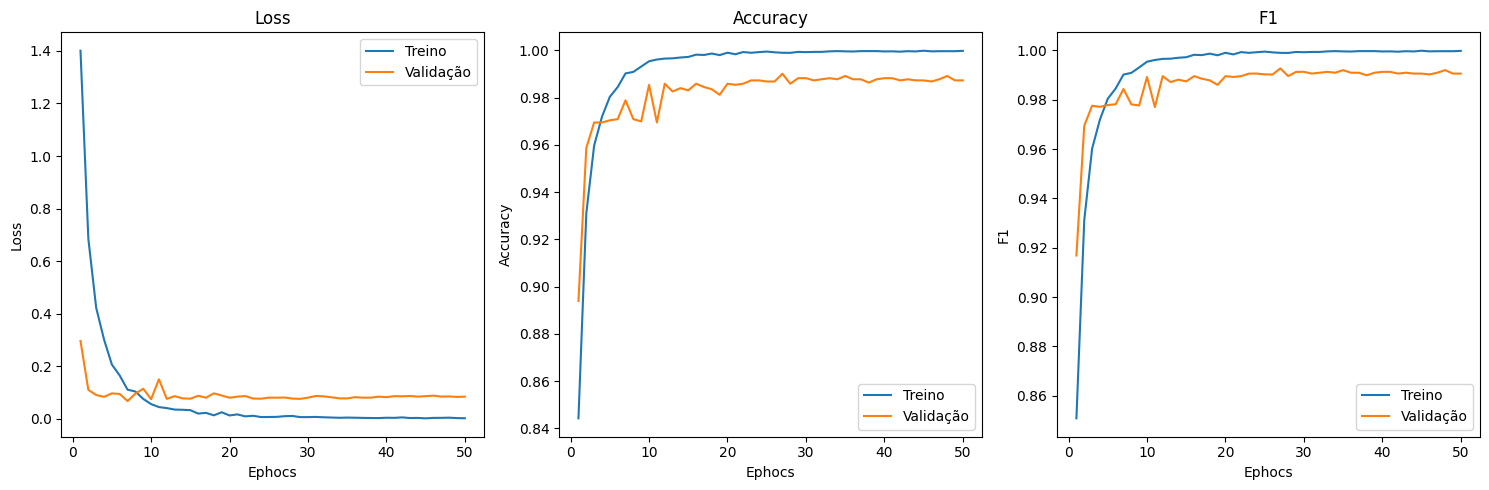

In [38]:
plot_metrics(metrics)

In [39]:
val_metrics = test_classification(classifier_model, val_dataloader, criterion, device)

Test loss: 0.0847 | Test accuracy: 0.9873 | Test precision: 0.9903 | Test recall: 0.9910 | Test F1: 0.9906



In [40]:
test_metrics = test_classification(classifier_model, test_dataloader, criterion, device)

Test loss: 0.0955 | Test accuracy: 0.9887 | Test precision: 0.9862 | Test recall: 0.9972 | Test F1: 0.9917



In [41]:
torch.save(classifier_model.state_dict(), 'parameters.pth')